In [1]:
import os

os.environ["OPENAI_API_KEY"] = ""

In [ ]:
from semantic_router.llms import OpenAILLM

llm = OpenAILLM(name="gpt-4o-2024-08-06")

In [3]:
from pydantic import BaseModel, Field


class Search(BaseModel):
    query: str = Field(description="Search query for internet information")

class Memory(BaseModel):
    query: str = Field(description="Self-directed query to search information from your long term memory")

In [4]:
import ast
import random
import openai
from graphai import router, node
from semantic_router.schema import Message


@node(start=True)
def node_start(input: dict):
    """Descriptive string for the node."""
    print("node_a")
    return {"input": input}


@router
def node_router(input: dict):
    print("node_router")
    query = input["query"]
    messages = [
        Message(
            role="system",
            content="""You are a helpful assistant. Select the best route to answer the user query. ONLY choose one function.""",
        ),
        Message(role="user", content=query),
    ]
    response = llm(
        messages=messages,
        function_schemas=[
            openai.pydantic_function_tool(Search),
            openai.pydantic_function_tool(Memory),
        ],
    )
    choice = ast.literal_eval(response)[0]
    print("choice", choice)
    return {
        "choice": choice["function_name"].lower(),
        "input": {**input, **choice["arguments"]},
    }


@node
def memory(input: dict):
    print("memory")
    query = input["query"]
    print("memory query", query)
    return {"input": {"text": "The user is in Bali right now.", **input}}


@node
def search(input: dict):
    print("search")
    query = input["query"]
    print("search query", query)
    return {
        "input": {
            "text": "The most famous photo spot in Bali is the Uluwatu Temple.",
            **input,
        }
    }


@node
def llm_node(input: dict):
    print("llm_node")
    chat_history = [
        Message(role=message["role"], content=message["content"])
        for message in input["chat_history"]
    ]

    messages = [
        Message(role="system", content="""You are a helpful assistant."""),
        *chat_history,
        Message(
            role="user",
            content=(
                f"Response to the following query from the user: {input['query']}\n"
                "Here is additional context. You can use it to answer the user query. "
                f"But do not directly reference it: {input.get('text', '')}."
            ),
        ),
    ]
    response = llm(messages=messages)
    return {"output": response}


@node(end=True)
def node_end(input: dict):
    """Descriptive string for the node."""
    print("node_end")
    return {"output": input["output"]}

In [5]:
from graphai import Graph

graph = Graph()

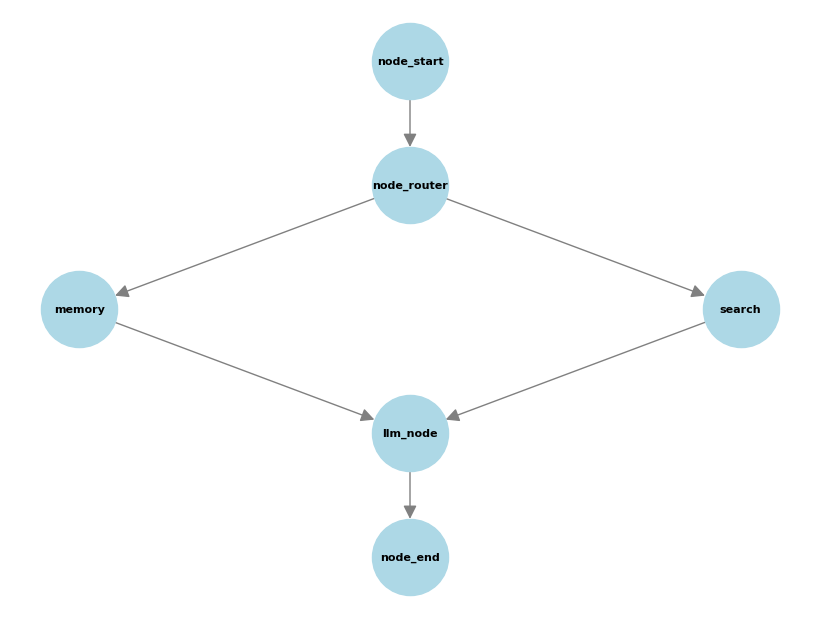

In [6]:
for node_fn in [node_start, memory, search, llm_node, node_end]:
    graph.add_node(node_fn)

# add the router
graph.add_router(
    source=node_start,
    router=node_router,
    destinations=[memory, search]
)

# build the certain edges
graph.add_edge(source=node_start, destination=node_router)
graph.add_edge(source=memory, destination=llm_node)
graph.add_edge(source=search, destination=llm_node)
graph.add_edge(source=llm_node, destination=node_end)

graph.visualize()

In [12]:
chat_history = []

In [13]:
def chat(query: str):
    chat_history.append({"role": "user", "content": query})
    response = graph.execute(input={"input": {"query": query, "chat_history": chat_history}})
    chat_history.append({"role": "assistant", "content": response["output"]})
    return response["output"]

In [14]:
chat("do you remember where I am?")

node_a
node_router
choice {'function_name': 'Memory', 'arguments': {'query': 'user location'}}
memory
memory query user location
llm_node


"You're currently in Bali. How can I assist you further?"

In [15]:
chat_history

[{'role': 'user', 'content': 'do you remember where I am?'},
 {'role': 'assistant',
  'content': "You're currently in Bali. How can I assist you further?"}]

In [16]:
chat("That's correct. Can you find me a good temple to visit?")

node_a
node_router
choice {'function_name': 'Search', 'arguments': {'query': 'best temples to visit'}}
search
search query best temples to visit
llm_node


"One of the best temples to visit in Bali is the Uluwatu Temple. It's not only a significant cultural site but also offers stunning views, especially at sunset. The temple is perched on a cliff overlooking the ocean, making it a popular spot for photography. Additionally, you can experience traditional Kecak dance performances there in the evening."

In [17]:
chat_history

[{'role': 'user', 'content': 'do you remember where I am?'},
 {'role': 'assistant',
  'content': "You're currently in Bali. How can I assist you further?"},
 {'role': 'user',
  'content': "That's correct. Can you find me a good temple to visit?"},
 {'role': 'assistant',
  'content': "One of the best temples to visit in Bali is the Uluwatu Temple. It's not only a significant cultural site but also offers stunning views, especially at sunset. The temple is perched on a cliff overlooking the ocean, making it a popular spot for photography. Additionally, you can experience traditional Kecak dance performances there in the evening."}]